# Chapter 7. Combining Different Models for Ensemble Learning

예를들어 앞으로의 경제 전망에 대해 전문가의 자문을 구해야 한다고 하자. 이런 경우 전문가 한명의 조언을 이용하는 것 보다 여러 전문가의 자문을 종합해 판단을 내리는 것이 더 합리적이라라는 것은 자명하다.

머신 러닝 기법에서도 한가지 모형을 사용해 예측을 하는 것이 아니라, 여러 모형의 예측 결과를 종합하여 최종 예측을 하는 방법을 사용할 수 있으며 일반적으로 개개의 모형보다 여러 모형을 종합하여 사용하는 것이 더 좋은 성능을 보인다.

이렇게 여러 모형을 종합하여 사용하는 방법을 앙상블 학습(Ensemble learning)이라 하며 이번 Chapter에서는 다양한 앙상블 학습 방법 중 아래 3가지 기법에 대해 알아본다.
- **Majority voting**
- **Bagging(=Boostrap aggregating)**
- **AdaBoost**      


### [1] Majority voting

우선 majority voting에 대해 알아보면..

> 3명의 재무 전문가($C_1, C_2, C_3$)가 있고 어떤 회사가 1년 이후 흥할지($\hat{y} = 1$) 혹은 망할지($\hat{y} = -1$)를 예측한다고 해 보자. 3명 전문가의 의견을 토대로 최종 예측을 내리는데, 전문가 두명 이상이 $\hat{y} = 1$이라 예측하면 최종 결론을 $\hat{y}_{ensemble} = 1$이라 내릴 것이고, 전문가 두명 이상이 $\hat{y} = -1$이라 예측하면 최종 결론을 $\hat{y}_{ensemble} = -1$이라 내릴 것이다.

$m$개의 classifier를 각각 $C_1, \dots, C_m$이라 하고, 데이터 벡터 $\mathbf{x}$에 대한 j번째 classifier $C_j$의 예측 label을 $C_j(\mathbf{x})$라 하자. 이때 데이터 벡터 $\mathbf{x}$에 대한 $m$개의 classifier의 예측결과중 가장 많은 표를 받은 label을 아래와 같이 표현할 수 있다.

$$\hat{y}_{ensemble} = mode\{ C_1(\mathbf{x}), C_2(\mathbf{x}), \dots, C_m(\mathbf{x}) \}$$

예를들어 이항 분류 문제($y_{label} \in \{ -1, 1\}$)의 경우 majority vote을 아래와 같이 표현할 수 있다.
$$\hat{y}_{ensemble} = sign \left[ \sum_j^m C_j(\mathbf{x})\right] = \begin{cases} 1 & if~\sum_j C_j(\mathbf{x}) \geq 0 \\ -1 & otherwise\end{cases}$$

앙상블 방법이 효과적인 이유를 간단히 살펴보자. 예를들어 n개의 분류기(classifier)가 있고 각 분류기의 오류 확률이 동일하게 $\epsilon$이라 할때 이들을 앙상블로 묶을 경우의 오류 확률을 계산해 보자. 앙상블 분류기가 오류가 나는 경우는 $n$개의 분류기의 절반 이상이 오 분류를 하는 경우들 이므로 이 확률($\epsilon_{ensemble}$)은 아래와 같이 계산할 수 있다. 또한 아래 ensemble_error 함수로도 계산할 수 있다.

$$P(y \geq k) = \sum_k^n {n \choose k} ~ \epsilon^k (1-\epsilon)^{n-k} = \epsilon_{ensemble}$$

예를들어 11개 분류기의 오류 확률이 각각 0.25일 경우, 앙상블 모형의 오류 확률은 0.034로서 그 오류 확률이 급격히 낮아짐을 알 수 있다.

In [1]:
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

이번에는 각 분류기의 오류 확률에 따라 앙상블 모형의 오류 확률은 어떤지 알아보자. 아래와 같이 각 분류기의 오류 확률(Base error)을 0(전부 정 예측)에서부터 0.5(무작위 예측) 1(전부 오 예측)까지 변화시키면서 앙상블 모형의 오류 확률을 그려볼 수 있다. 즉 각 분류기의 오류 확률이 0.5보다 낮은 경우 앙상블 모형이 더 좋은 성능을 보이고, 각 분류기의 오류 확률이 0.5를 넘을 경우 앙상블 모형이 더 좋은 성능을 보이게 된다.

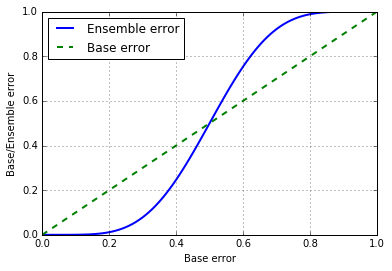

In [25]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) 
              for error in error_range]

import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### [1] Majority voting - Implementing majority vote classifier

> 앞서 3명의 재무 전문가($C_1, C_2, C_3$) 예에서는 3명의 의견을 동일한 중요도로 판단 했었다. 그런데 전문가 $C_1$는 매우 저명하고 $C_2$는 일반적인 전문가이며 $C_3$는 그렇게 신뢰하기는 어려운 전문가라고 해 보자. 이럴 경우 각 전문가의 예측을 다른 비중으로 최종 결과에 반영해야 할 것이다. 

> 예를들어 $C_1$에는 2의 가중치를, $C_2$에는 1의 가중치를, $C_3$에는 0.5의 가중치를 부여하여 최종 의견을 아래와 같이 계산할 수 있다.
$$\hat{y}_{ensemble} = \begin{cases} 1 & if ~ 2C_1(\mathbf{x}) + C_2 (\mathbf{x}) + 0.5 C_3 (\mathbf{x})> 0 \\ -1 & otherwise ~  \end{cases}$$

즉 $m$개의 이항 예측 분류기에 대한 앙상블 예측을 아래와 같이 표현할 수 있다.
$$\hat{y}_{ensemble} = sign \left[ \sum_j^m w_j C_j(\mathbf{x})\right] = \begin{cases} 1 & if~\sum_j C_j(\mathbf{x}) \geq 0 \\ -1 & otherwise\end{cases}$$

좀 더 일반적으로 이항예측이 아니라 다항 예측의 경우 앙상블 예측결과를 아래와 같이 표현할 수 있다.
$$\hat{y}_{ensemble} = \mathrm{arg}~\mathrm{max}_i ~ \sum_{j=1}^m w_j ~ \chi_A \left( C_j(\mathbf{x})=i\right)$$

혹은 각 분류기($C_j$)의 결과로 각 label($i$)에 대한 예측 확률($p_{ij}$이 주어진다면 앙상블 예측 확률을 아래와 같이 표현할 수 있다.
$$\hat{y}_{ensemble} = \mathrm{arg}~\mathrm{max}_i ~ \sum_{j=1}^m w_j ~ p_{ij}$$

> 이렇게 가중치가 부여된 여러 항에 대한 $\mathrm{arg} ~ \mathrm{max}$는 아래와 같이 numpy의 average 함수와 argmax함수를 이용하여 계산할 수 있다.

In [26]:
ex = np.array([[0.9, 0.1]
               , [0.8, 0.2]
               , [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [27]:
np.argmax(p)

0

fitting된 여러 classifier에 Majority vote을 적용한 예측 결과를 출력하는 새로운 Classifier를 아래와 같이 구현해 볼 수 있다.

In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    
    vote : str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on
        the argmax of class labels. Else if
        'probability', the argmax of the sum of
        probabilities is used to predict the class label
        (recommended for calibrated classifiers).
        
    weights : array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of `int` or `float` values are
        provided, the classifiers are weighted by
        importance; Uses uniform weights if `weights=None`.
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix},
        shape = [n_samples, n_features]
        Matrix of training samples.
        y : array-like, shape = [n_samples]
        Vector of target class labels.
        Returns
        -------
        self : object
        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.
        
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights))
                                           , axis=1
                                           , arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.
            
        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

### Combining different algorithms for classification with majority vote

앞서 구현된 MajorityVoteClassifier를 사용해볼 차례인데, 테스트를 위해 Iris 데이터 셋을 사용할 것이다. 우선 이항 분류만 테스트 하기 위해 target값이 1과 2인 51번째 행 부터 사용할 것이며 변수 또한 sepal width와 petal length만을 사용할 것이다.

In [51]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [52]:
import pandas as pd
import pandasql as pdsql
irid_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

pysql = lambda q: pdsql.sqldf(q, globals())
print(pysql("select target, count(1) from irid_df group by target;"))
pysql("select * from irid_df limit 5;")

   target  count(1)
0     0.0        50
1     1.0        50
2     2.0        50


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

비교할 Classifier로는 로지스틱 회귀모형(LogisticRegression), 의사결정 나무(DecisionTreeClassifier), k-최근접 이웃 알고리즘(KNeighborsClassifier)를 사용할 것이며, 이들을 우리의 training 데이터로 학습시키고 그 결과를 앞서 만들었던 MajorityVoteClassifier에 넣어 그 성능을 최초 3개의 알고리즘의 성능과 비교할 것이다.

In [65]:
# p211

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


위와 같이 3개의 분류기(로지스틱 회귀모형, 의사결정 나무, k-최근접 이웃 알고리즘)의 능이 거의 비슷함을 알 수 있다.

In [68]:
# p212
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


MajorityVoteClassifier를 이용한 경우 그 정확도가 0.97로 약간 향상됨을 알 수 있다.

### Evaluating and tuning the ensemble classifier

앞서 계산하고 비교 했던 ROC AUC값은 training 데이터에 대한 값이었고, 모형이 얼마나 잘 일반화(generalize)되는지 알아보기 위해 test 데이터에 대한 성능을 통해 보다 객관적인 모형 평가를 할 수 있다.

아래와 같이 test 데이터에 대한 각 3개의 독립 모형과 하나의 Majority voting 모형의 ROC Curve를 그려보고, AUC 값을 계산해 보면 역시나 Majority voting 모형의 성능이 가장 우수함을 알 수 있고,  k-최근접 이웃 알고리즘의 경우 training 데이터에 비해 그 성능이 크게 떨어져서 overfitting이 진행되었음을 알 수 있다.

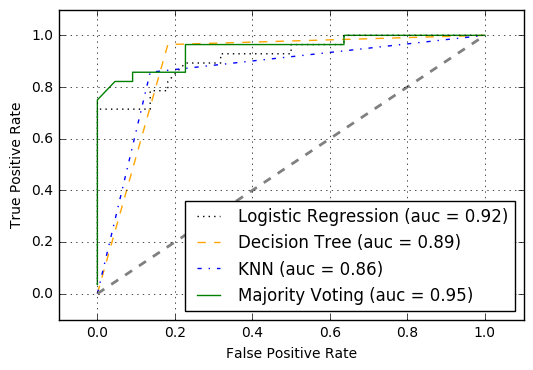

In [69]:
# p213
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib auto

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

이번에는 각 3개의 독립 모형과 하나의 Majority voting 모형의 Decision region을 그려보고 이를 통해 각 모형의 차이를 시각으로 살펴보면, 아래 그림과 같이 4개 모형의 Decision boundary가 조금식 다르며, KNN과 Majority Voting의 Decision boundary가 유사함을 알 수 있다.

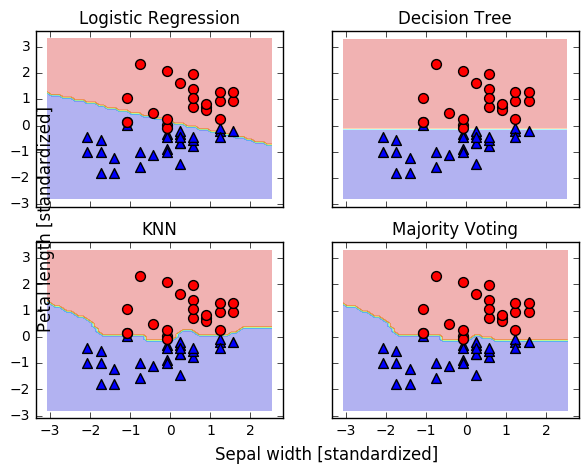

In [70]:
# p214

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0]
                                  , X_train_std[y_train==0, 1]
                                  , c='blue'
                                  , marker='^'
                                  , s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0]
                                  , X_train_std[y_train==1, 1]
                                  , c='red'
                                  , marker='o'
                                  , s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

앞서 MajorityVoteClassifier에 넣을 모형을 학습 시킬 때, 각 모형의 hyper-parameter(Decision tree max depth, Regularization parameter 등)를 임의의 값으로 설정했었다. 하지만 보다 나은 모형을 만들기 위해서는 최적의 hyper-parameter 값을 찾는 과정도 필요하다. 

예를들어 결정해야하는 hyper-parameter가 $\alpha$와 $\beta$ 두 개가 있고 $\alpha$의 후보값으로 {1, 2}이, $\beta$의 후보값으로 {0001, 0.1, 100.0}이 있다면 두 hyper-parameter의 조합은 6가지가 있다. 어떤 조합이 가장 좋은지 찾는 가장 단순한 방법은 모든 경우에 대한 모형 학습을 진행하고 정확도 등 평가 값이 가장 좋아지는 값을 선택하는 것이다.

이렇게 모든 경우에 대한 시도를 하는 방법을 Grid search라 하며 scikit-learn에서는 GridSearchCV로 제공된다.

앞서 만들었던 MajorityVoteClassifier에 대한 Grid search를 진행하기에 앞서 모형 파라미터가 어떤 형태로 저장되는지 확인하기 위해 아래와 같이 get_params 함수를 이용해 살펴볼 수 있다.

In [71]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=

Decision tree max depth와 (Inverse)Regularization parameter는 각각 'decisiontreeclassifier\__max_depth'와 'pipeline-1\__clf\__C'로 존재하며      
GridSearchCV를 이용하여 'decisiontreeclassifier\__max_depth'는 {1, 2}를, 'pipeline-1\__clf\__C'는 {0001, 0.1, 100.0}를 대상으로 아래와 같이 Grid search를 해 볼 수 있다.

In [72]:
# p217

from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [73]:
# p218

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))

0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [74]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 1.00


### [2] Bagging - building an ensemble of classifiers from bootstrap samples

두번째로 Bagging에 대해 알아볼텐데, Bagging은 Bootstrap aggregating이라고도 부른다.

우선 Bootstrapping이란 일종의 resampling 방법으로서    
크기(건수)가 $n$인 어떤 sample set $C$에서        
$n$개 혹은 $k( \leq n)$개의 sample을 복원 추출(with replacement)한     
sample set $C_i$을 여러개($C_1, \dots, C_m$) 만드는 것을 말한다.

이렇게 만들어진 새로운 sample set($C_i$)을 bootstrap sample이라 한다.

<img  src="./_images/07_1.PNG"/>

.

In [12]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label'
                   , 'Alcohol'
                   , 'Malic acid'
                   , 'Ash'
                   , 'Alcalinity of ash'
                   , 'Magnesium'
                   , 'Total phenols'
                   , 'Flavanoids'
                   , 'Nonflavanoid phenols'
                   , 'Proanthocyanins'
                   , 'Color intensity'
                   , 'Hue'
                   , 'OD280/OD315 of diluted wines'
                   , 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [14]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree
                        , n_estimators=500
                        , max_samples=1.0
                        , max_features=1.0
                        , bootstrap=True
                        , bootstrap_features=False
                        , n_jobs=1
                        , random_state=1)

In [15]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [16]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


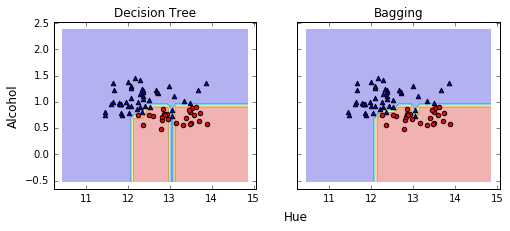

In [17]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
    X_train[y_train==0, 1],
    c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

### [3] AdaBoost - Leveraging weak learners via adaptive boosting

In [19]:
# p229

from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.845/0.854


In [20]:
# p229
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.875


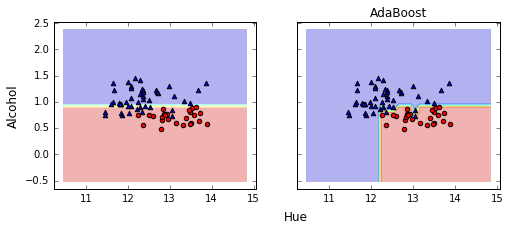

In [22]:
# p230

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()